# Synthetic Datasets - 1D examples

## Linear Trend and sinusoidal modulation 

     X     Alpha  t
0  0.1  0.335532  0
1  0.1  0.335532  1
2  0.1  0.335532  0
3  0.1  0.335532  0
4  0.1  0.335532  0


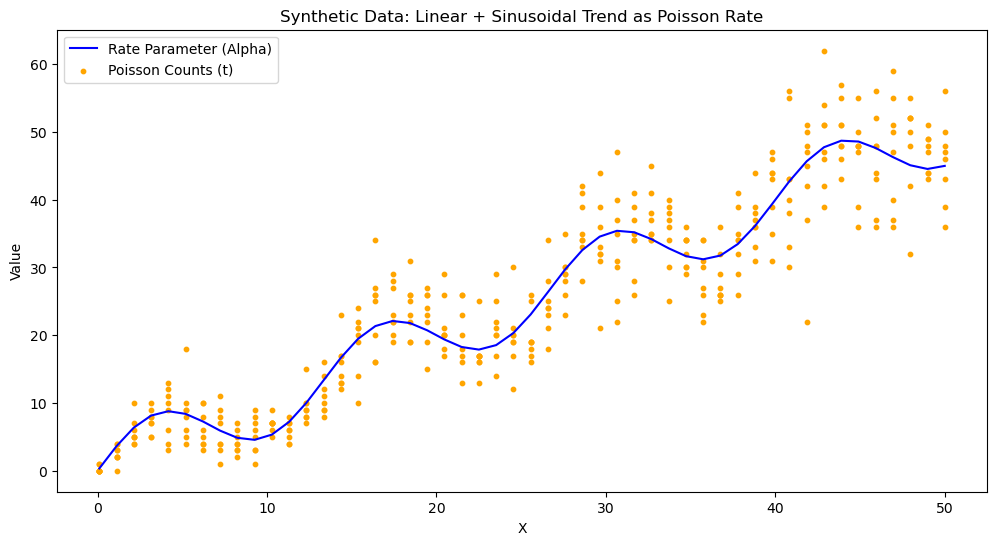

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


seed_value = 42
np.random.seed(seed_value)

# Parameters for the linear and sinusoidal trends
slope = 1  # Slope for the linear trend
amplitude = 5  # Amplitude for the sinusoidal trend
frequency = 0.075  # Frequency for the sinusoidal trend

# Generate unique feature data X
n_samples = 50 # Number of unique X values
X_unique = np.linspace(0.1, 50, n_samples)  # Unique X values range from 0 to 50

# Number of instances per unique X value
n_instances_per_X = 8

# Initialize lists to store the expanded data
X_expanded = []
Alpha_expanded = []  # Represents λ(X)
t_expanded = []  # Represents Poisson counts

# Iterate over each unique X value
for x in X_unique:
    # Generate the rate parameter λ(X) as a combination of linear and sinusoidal trends
    lambda_x = slope * x + amplitude * np.sin(2 * np.pi * frequency * x)
    lambda_x = max(lambda_x, 0)  # Ensure non-negativity
    # Generate multiple Poisson counts for the current X
    poisson_counts = np.random.poisson(lambda_x, n_instances_per_X)
    # Append the current X, its lambda_x, and corresponding Poisson counts to the lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_expanded.extend([lambda_x] * n_instances_per_X)
    t_expanded.extend(poisson_counts)

# Combine X, Alpha, and t into a DataFrame
data = pd.DataFrame({
    'X': X_expanded,
    'Alpha': Alpha_expanded,
    't': t_expanded
})


# Display the first few rows
print(data.head())

# Visualization of the generated data
plt.figure(figsize=(12, 6))
plt.plot(X_unique, slope * X_unique + amplitude * np.sin(2 * np.pi * frequency * X_unique), label='Rate Parameter (Alpha)', color='blue')
plt.scatter(X_expanded, t_expanded, color='orange', s=10, label='Poisson Counts (t)')
plt.title("Synthetic Data: Linear + Sinusoidal Trend as Poisson Rate")
plt.xlabel("X")
plt.ylabel("Value")
plt.legend()
plt.show()


In [7]:
X = np.array(X_expanded)
t = np.array(t_expanded)
alpha_x = np.array(Alpha_expanded)

In [15]:
from scipy.optimize import minimize

# Initial parameters
theta_init = np.array([6.86590225, 12.05566956], dtype=np.float64)

# Optimize the log-likelihood
result = minimize(
    fun= neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    jac=gradient_log_likelihood,
    method='BFGS'
    )


# Print the optimization results
print("Optimized parameters:", result.x)
print("Log-likelihood at optimum:", (-1)*result.fun)

Optimized parameters: [ 6.95992396 12.05066704]
Log-likelihood at optimum: 24069.464519088644


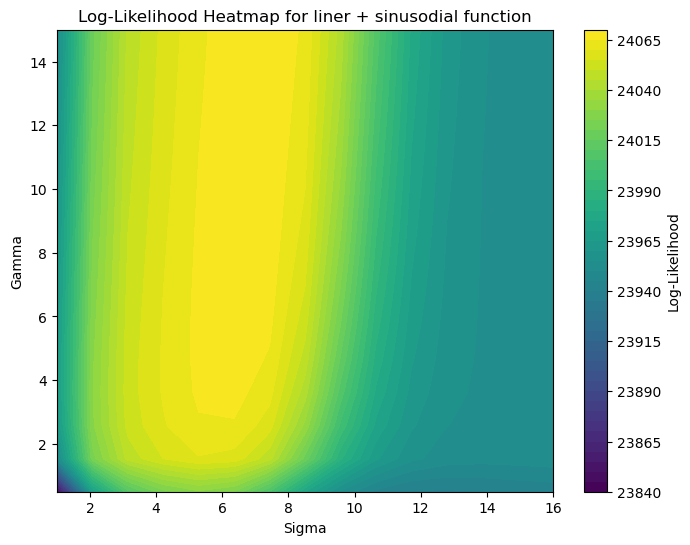

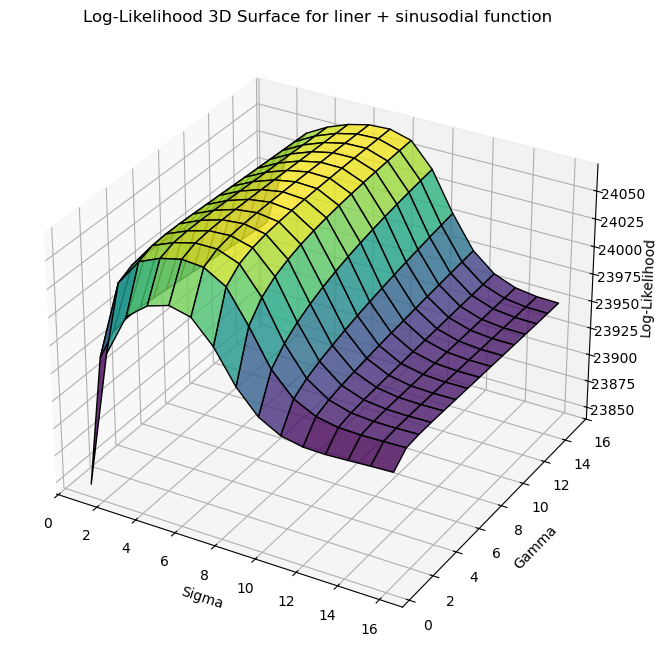

In [74]:
# take 2
from scipy.stats import multivariate_normal, poisson
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming compute_cov_matrix, compute_gradient, and compute_hessian are defined

# Define parameter ranges
sigma_values = np.linspace(1, 16, 15)  # Sigma values
gamma_values = np.linspace(0.5, 15.0, 15)  # Gamma values

# Create a grid of parameters
param_grid = list(itertools.product(sigma_values, gamma_values))

# Initialize storage for log-likelihood values
log_likelihoods = np.zeros((len(sigma_values), len(gamma_values)))

# Iterate over the parameter grid
for i, sigma in enumerate(sigma_values):
    for j, gamma in enumerate(gamma_values):
        # Compute covariance matrix with the extended RBF kernel
        Cn = compute_cov_matrix(X, sigma=sigma, gamma=gamma, regularization=1e-6)
        
        # Initialize lambda
        lambda_init = np.ones(X.shape[0])
        
        # Perform Newton's optimization
        for k in range(500):
            grad_f = compute_gradient(t, lambda_init, Cn)
            H = compute_hessian(Cn, lambda_init)
            change = 0.05 * np.linalg.inv(H).dot(grad_f)
            lambda_init += change
            if np.max(np.abs(change)) < 1e-6:
                break
        
        # Compute the log-likelihood
        log_likelihood = t.T @ lambda_init - np.sum(np.exp(lambda_init)) -0.5 *log_det_cholesky((compute_hessian(Cn, lambda_init))) \
                        + multivariate_normal.logpdf(lambda_init, mean=np.zeros(X.shape[0]), cov= Cn)
        # Store the log-likelihood value
        log_likelihoods[i, j] = log_likelihood

# Plotting the landscape
sigma_grid, gamma_grid = np.meshgrid(sigma_values, gamma_values)

# Heatmap
plt.figure(figsize=(8, 6))
plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, levels=50, cmap="viridis")
plt.colorbar(label="Log-Likelihood")
plt.title("Log-Likelihood Heatmap for liner + sinusodial function")
plt.xlabel("Sigma")
plt.ylabel("Gamma")
plt.show()

# 3D Surface Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(sigma_grid, gamma_grid, log_likelihoods.T, cmap="viridis", edgecolor="k", alpha=0.8)
ax.set_title("Log-Likelihood 3D Surface for liner + sinusodial function")
ax.set_xlabel("Sigma")
ax.set_ylabel("Gamma")
ax.set_zlabel("Log-Likelihood")
plt.show()


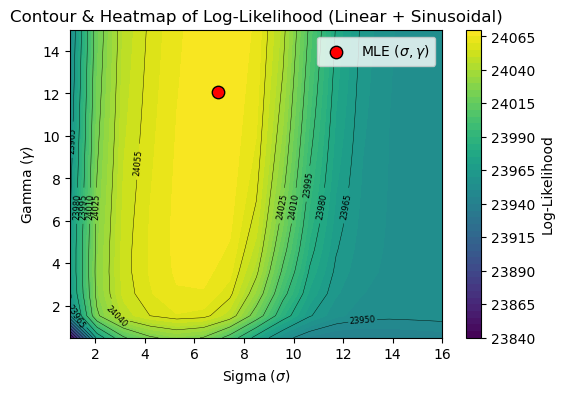

In [147]:
# log-likelihood Countour+Heatmap with the optimum value marked

highlight_sigma = 6.960
highlight_gamma = 12.051

plt.figure(figsize=(6, 4))
contourf = plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, 
                        levels=50, cmap="viridis")  
contour = plt.contour(sigma_grid, gamma_grid, log_likelihoods.T, 
                      levels=15, colors="k", linewidths=0.3)
plt.clabel(contour, inline=True, fontsize=6, fmt="%.0f")
plt.colorbar(contourf, label="Log-Likelihood")

# Mark the special point
plt.scatter(highlight_sigma, highlight_gamma, 
            color="red", s=80, marker="o", edgecolor="k", 
            label="MLE (${\sigma},{\gamma}$)")

plt.title("Contour & Heatmap of Log-Likelihood (Linear + Sinusoidal)")
plt.xlabel(r"Sigma ($\sigma$)")
plt.ylabel(r"Gamma ($\gamma$)")
plt.legend()
plt.show()


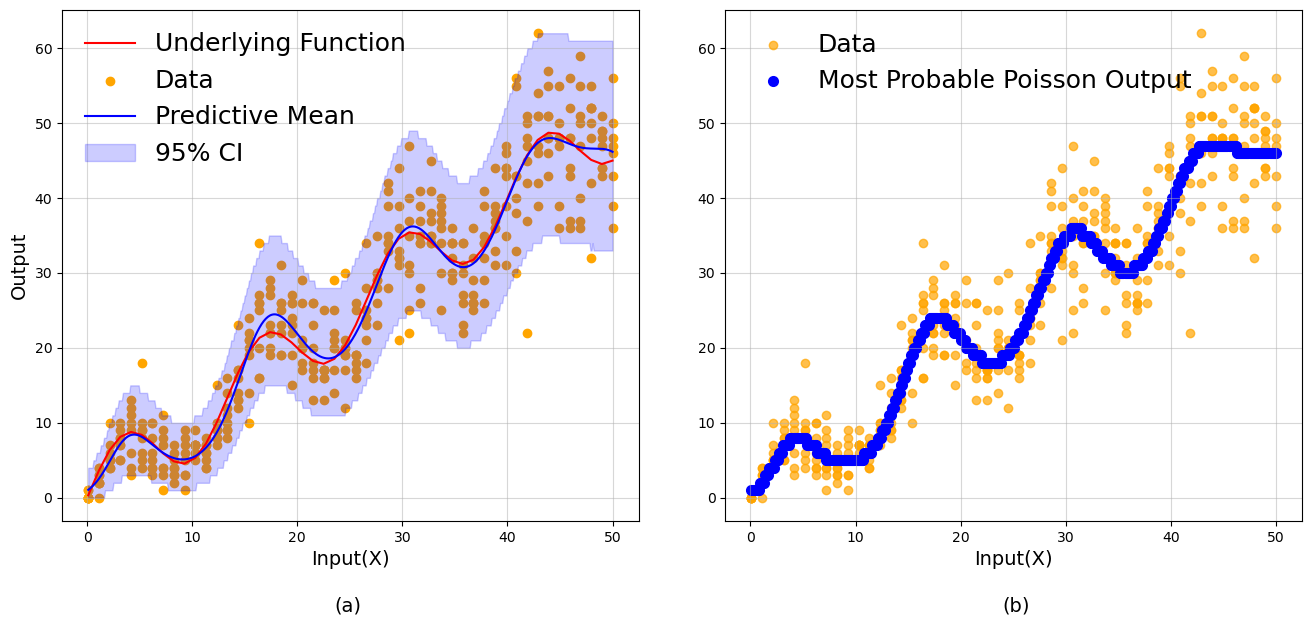

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, poisson

6.960, 12.051

import matplotlib.pyplot as plt
sigma = 6.960
gamma = 12.051 
Cn = compute_cov_matrix(X, sigma=sigma, gamma=gamma, regularization=1e-6)
    
# Initialize lambda
lambda_init = np.ones(X.shape[0])

# Perform Newton's optimization
for i in range(500):
    grad_f = compute_gradient(t, lambda_init, Cn)
    H = compute_hessian(Cn, lambda_init)
    change = 0.05 * np.linalg.inv(H).dot(grad_f)
    lambda_init += change
    if np.max(change) < 1e-6:
        break


# Define input space for predictions
X_input = np.linspace(0.1, 50, 500)

lambda_predicted = lambda_init
# Storage for predictions
mu_values = []
std_values = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input:
    K = compute_K(X, X_new, sigma= 6.960 , gamma= 12.051)  # Compute K for each X_new
    mean_lambda_nplus1_given_data = K.T @ np.linalg.inv(Cn) @ lambda_predicted  # Predictive mean

    # Variance calculations
    H = compute_hessian(Cn, lambda_predicted)
    c = rbf_kernel_extended(X_new, X_new, sigma= 6.960 , gamma= 12.051) + 1e-6
    var_lambda_nplus1_given_data = abs(
        c - K.T @ np.linalg.inv(Cn) @ K +
        K.T @ np.linalg.inv(Cn) @ np.linalg.inv(H) @ np.linalg.inv(Cn) @ K
    )

    # Append results to the storage
    mu_values.append(mean_lambda_nplus1_given_data.item())
    std_values.append(np.sqrt(var_lambda_nplus1_given_data))

# Convert lists to arrays
mu_values = np.array(mu_values)
std_values = np.array(std_values)

poissoin_output = []
sigma_poissoin = []
for mu, sigma in zip(mu_values, std_values):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log))
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))

    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)

# Monte Carlo parameters
n_samples = 10000 # Number of Monte Carlo samples
k_range = np.arange(0, 80)  # Range of k to evaluate

# Storage for most probable Poisson outputs and confidence intervals
most_probable_output = []
confidence_intervals = []

for mu, sigma in zip(mu_values, std_values):
    # Sample lambda from log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))

    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))

most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bounds = confidence_intervals[:, 0]
upper_bounds = confidence_intervals[:, 1]


# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
axes[0].plot(X, alpha_x, label="Underlying Function", color="red")
axes[0].scatter(X, t, label="Data", color="orange")
axes[0].plot(X_input, poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(X_input, lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI")
axes[0].set_xlabel("Input(X)", fontsize=14)
axes[0].set_ylabel("Output", fontsize=14)
axes[0].legend(fontsize=18, loc ="best", frameon=False)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
axes[1].scatter(X, t, label="Data", color="orange", alpha=0.7)
axes[1].scatter(X_input, most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)
axes[1].set_xlabel("Input(X)", fontsize=14)
axes[1].legend(fontsize=18, loc ="best", frameon=False)
axes[1].grid(alpha=0.5)

# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.7125, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Save the figure (optional, for including in your paper)
plt.savefig("lin+quad.png", dpi=300)

# Show the plots
plt.show()


## Quadratic Trend and sinusoidal modulation 

     X     Alpha  t
0  0.1  2.571542  4
1  0.1  2.571542  1
2  0.1  2.571542  3
3  0.1  2.571542  3
4  0.1  2.571542  1


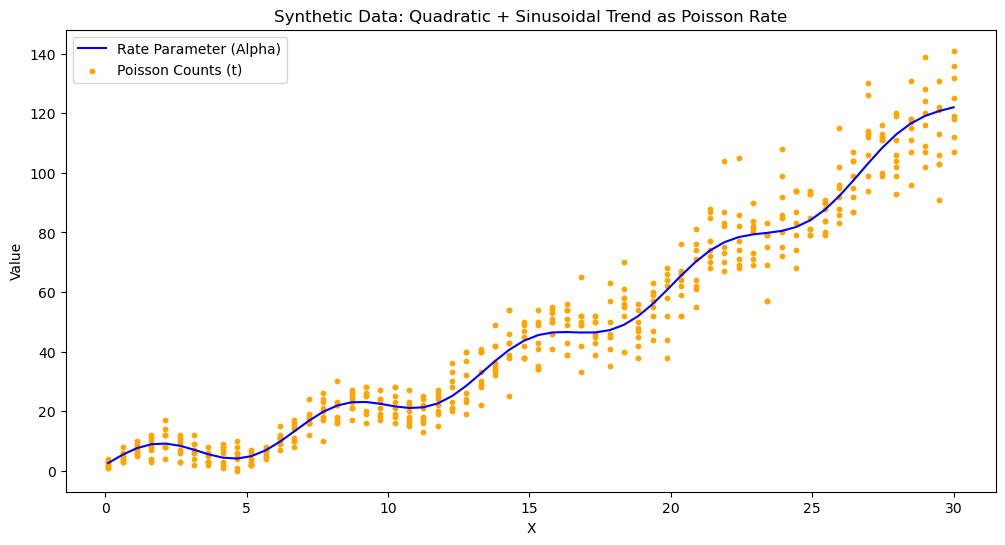

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)
# Parameters for the quadratic and sinusoidal trends
a = 0.1  # Coefficient for the quadratic term
b = 1.0  # Coefficient for the linear term
c = 2.0  # Constant offset
amplitude = 5  # Amplitude for the sinusoidal trend
frequency = 0.15  # Frequency for the sinusoidal trend

# Generate unique feature data X
n_samples = 60 # Number of unique X values
X_unique = np.linspace(0.1, 30, n_samples)  # Unique X values range from 0.1 to 30

# Number of instances per unique X value
n_instances_per_X = 8

# Initialize lists to store the expanded data
X_expanded = []
Alpha_expanded = []  # Represents λ(X)
t_expanded = []  # Represents Poisson counts

# Iterate over each unique X value
for x in X_unique:
    # Generate the rate parameter λ(X) as a combination of quadratic and sinusoidal trends
    lambda_x = a * x**2 + b * x + c + amplitude * np.sin(2 * np.pi * frequency * x)
    lambda_x = max(lambda_x, 0)  # Ensure non-negativity
    # Generate multiple Poisson counts for the current X
    poisson_counts = np.random.poisson(lambda_x, n_instances_per_X)
    # Append the current X, its lambda_x, and corresponding Poisson counts to the lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_expanded.extend([lambda_x] * n_instances_per_X)
    t_expanded.extend(poisson_counts)

# Combine X, Alpha, and t into a DataFrame
data = pd.DataFrame({
    'X': X_expanded,
    'Alpha': Alpha_expanded,
    't': t_expanded
})

# Display the first few rows
print(data.head())

# Visualization of the generated data
plt.figure(figsize=(12, 6))
plt.plot(
    X_unique, 
    a * X_unique**2 + b * X_unique + c + amplitude * np.sin(2 * np.pi * frequency * X_unique),
    label='Rate Parameter (Alpha)', 
    color='blue'
)

plt.scatter(X_expanded, t_expanded, color='orange', s=10, label='Poisson Counts (t)')
plt.title("Synthetic Data: Quadratic + Sinusoidal Trend as Poisson Rate")
plt.xlabel("X")
plt.ylabel("Value")
plt.legend()
plt.show()


t = t_expanded
X = X_expanded

In [85]:
from scipy.optimize import minimize

# Initial parameters
theta_init = np.array([3.5,7.5], dtype=np.float64)

# Optimize the log-likelihood
result = minimize(
    fun= neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    jac=gradient_log_likelihood,
    method='BFGS'
    )


# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.3f}, {result.x[1]:.3f}]")
print(f"Log-likelihood at optimum: {-result.fun:.3f}")

Optimized parameters: [3.433, 9.794]
Log-likelihood at optimum: 72087.182


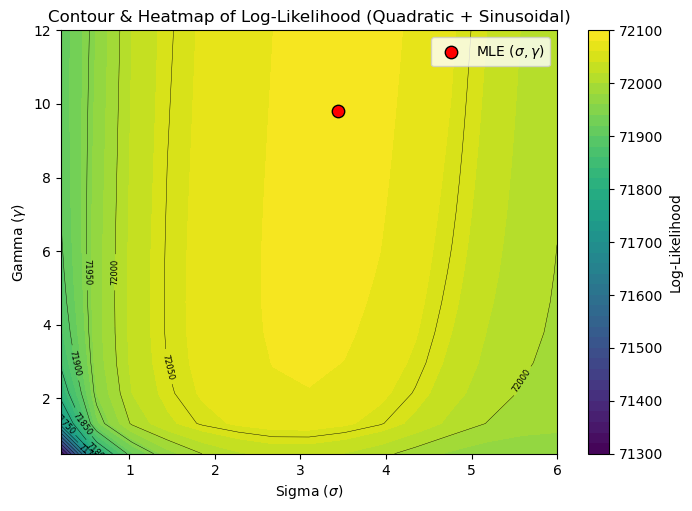

In [157]:
highlight_sigma = 3.433
highlight_gamma = 9.794

plt.figure(figsize=(8,5.5))
contourf = plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, 
                        levels=50, cmap="viridis")  
contour = plt.contour(sigma_grid, gamma_grid, log_likelihoods.T, 
                      levels=15, colors="k", linewidths=0.3)
plt.clabel(contour, inline=True, fontsize=6, fmt="%.0f")
plt.colorbar(contourf, label="Log-Likelihood")

# Mark the special point
plt.scatter(highlight_sigma, highlight_gamma, 
            color="red", s=80, marker="o", edgecolor="k", 
            label="MLE (${\sigma},{\gamma}$)")

plt.title("Contour & Heatmap of Log-Likelihood (Quadratic + Sinusoidal)")
plt.xlabel(r"Sigma ($\sigma$)")
plt.ylabel(r"Gamma ($\gamma$)")
plt.legend()
plt.show()


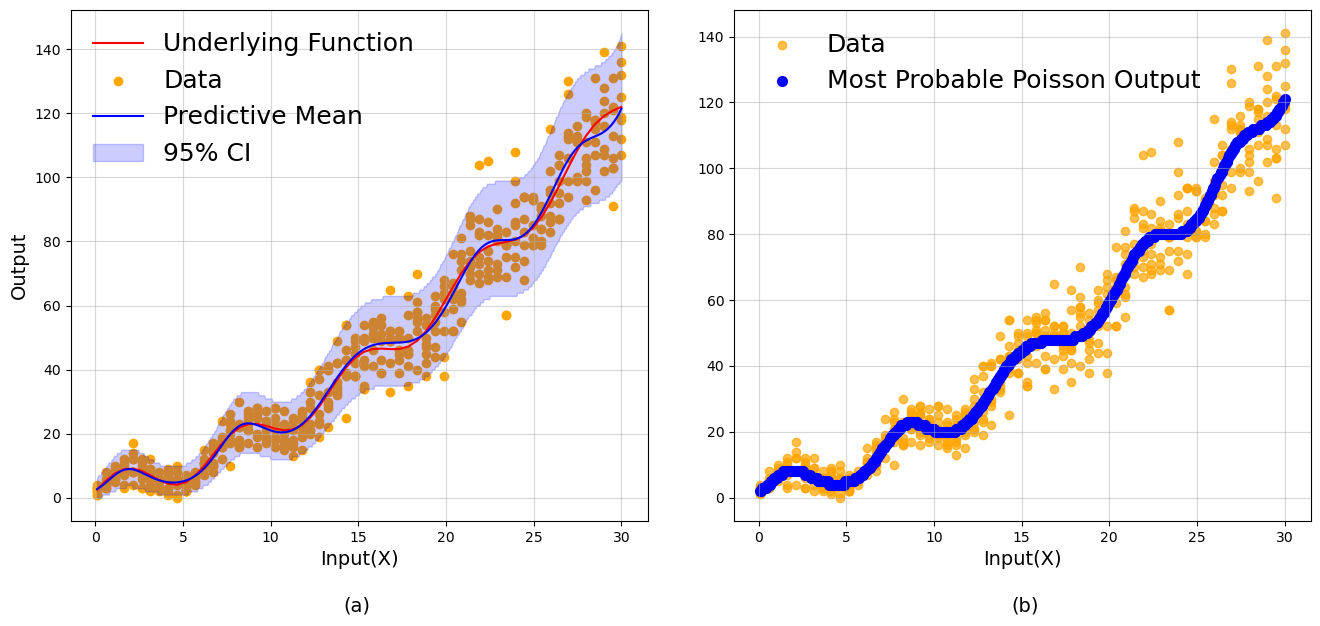

In [17]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array(X_expanded)
t = np.array(t_expanded)
alpha_x = np.array(Alpha_expanded)

import matplotlib.pyplot as plt
sigma = 3.433
gamma = 9.794 
Cn = compute_cov_matrix(X, sigma=sigma, gamma=gamma, regularization=1e-6)
    
# Initialize lambda
lambda_init = np.ones(X.shape[0])

# Perform Newton's optimization
for i in range(500):
    grad_f = compute_gradient(t, lambda_init, Cn)
    H = compute_hessian(Cn, lambda_init)
    change = 0.05 * np.linalg.inv(H).dot(grad_f)
    lambda_init += change
    if np.max(change) < 1e-6:
        break


# Define input space for predictions
X_input = np.linspace(0.1, 30, 500)

lambda_predicted = lambda_init
# Storage for predictions
mu_values = []
std_values = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input:
    K = compute_K(X, X_new, sigma= 3.433 , gamma= 9.794)  # Compute K for each X_new
    mean_lambda_nplus1_given_data = K.T @ np.linalg.inv(Cn) @ lambda_predicted  # Predictive mean

    # Variance calculations
    H = compute_hessian(Cn, lambda_predicted)
    c = rbf_kernel_extended(X_new, X_new, sigma= 3.433 , gamma= 9.794) + 1e-6
    var_lambda_nplus1_given_data = abs(
        c - K.T @ np.linalg.inv(Cn) @ K +
        K.T @ np.linalg.inv(Cn) @ np.linalg.inv(H) @ np.linalg.inv(Cn) @ K
    )

    # Append results to the storage
    mu_values.append(mean_lambda_nplus1_given_data.item())
    std_values.append(np.sqrt(var_lambda_nplus1_given_data))

# Convert lists to arrays
mu_values = np.array(mu_values)
std_values = np.array(std_values)

poissoin_output = []
sigma_poissoin = []
for mu, sigma in zip(mu_values, std_values):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log))
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))

    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)







# Monte Carlo parameters
n_samples = 10000 # Number of Monte Carlo samples
k_range = np.arange(0, 160)  # Range of k to evaluate

# Storage for most probable Poisson outputs and confidence intervals
most_probable_output = []
confidence_intervals = []

for mu, sigma in zip(mu_values, std_values):
    # Sample lambda from log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))

    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))

most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bounds = confidence_intervals[:, 0]
upper_bounds = confidence_intervals[:, 1]


# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
axes[0].plot(X, alpha_x, label="Underlying Function", color="red")
axes[0].scatter(X, t, label="Data", color="orange")
axes[0].plot(X_input, poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(X_input, lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI")
axes[0].set_xlabel("Input(X)", fontsize=14)
axes[0].set_ylabel("Output", fontsize=14)
axes[0].legend(fontsize=18, loc ="best", frameon=False)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
axes[1].scatter(X, t, label="Data", color="orange", alpha=0.7)
axes[1].scatter(X_input, most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)
axes[1].set_xlabel("Input(X)", fontsize=14)
axes[1].legend(fontsize=18, loc ="best", frameon=False)
axes[1].grid(alpha=0.5)

# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.7125, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Save the figure (optional, for including in your paper)
plt.savefig("lin+quad.png", dpi=300)

# Show the plots
plt.show()


## Sinusoidal modulation 

     X      Alpha   t
0  0.2  64.991671  62
1  0.2  64.991671  71
2  0.2  64.991671  56
3  0.2  64.991671  67
4  0.2  64.991671  74


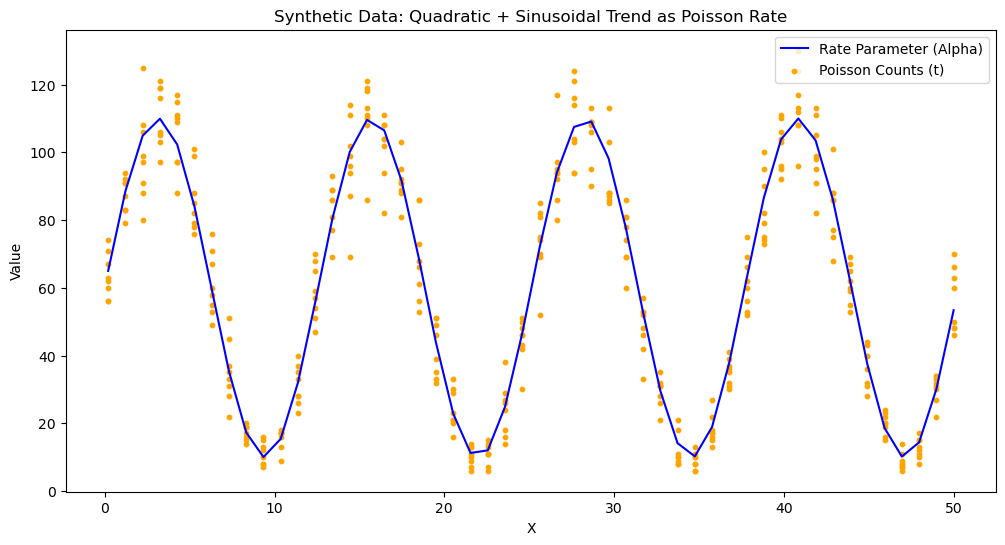

In [18]:
# Parameters for the sinusoidal function x(t) = c * sin(frequency * t)
amplitude = 50  # Large amplitude for the sinusoidal wave
frequency = 0.5 # Frequency of the sinusoidal wave
np.random.seed(42)
# Number of unique X (time) values to generate
n_samples = 50 # Number of unique time values

# Generate unique time points (input X values)
X_unique = np.linspace(0.2, 50, n_samples)  # Time values from 0 to 25

# Number of instances per unique time value
n_instances_per_X = 8

# Initialize lists to store the expanded data
X_expanded = []
Alpha_expanded = []
t_expanded = []

# Iterate over each unique X (time) value
for x in X_unique:
    alpha_x = amplitude * np.sin(frequency * x) + 60  # Calculate the rate parameter for the current X
    #alpha_x = max(alpha_x, 0)  # Ensure non-negativity for lambda (Poisson parameter)
    # Generate multiple t values from Poisson distribution with λ = alpha_x
    t_values = np.random.poisson(alpha_x, n_instances_per_X)
    # Append the current X, its alpha_x, and corresponding t values to the lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_expanded.extend([alpha_x] * n_instances_per_X)
    t_expanded.extend(t_values)

# Combine X, Alpha, and t into a DataFrame
data = pd.DataFrame({
    'X': X_expanded,  # Original input X values
    'Alpha': Alpha_expanded,  # Calculated rate parameter (sinusoidal function)
    't': t_expanded  # Poisson-distributed target values
})

# Save the dataset to a CSV file (optional)
data.to_csv('synthetic_data_sinusoidal_wave.csv', index=False)

# Display the first few rows
print(data.head())

# Convert to numpy arrays
X = np.array(X_expanded)  # Original input X values
t = np.array(t_expanded)  # Poisson-distributed target values
alpha_x = np.array(Alpha_expanded)  # Rate parameter values (sinusoidal)


# Visualization of the generated data
plt.figure(figsize=(12, 6))
plt.plot(
    X_unique, 
    amplitude * np.sin(frequency * X_unique) + 60,
    label='Rate Parameter (Alpha)', 
    color='blue'
)

plt.scatter(X_expanded, t_expanded, color='orange', s=10, label='Poisson Counts (t)')
plt.title("Synthetic Data: Quadratic + Sinusoidal Trend as Poisson Rate")
plt.xlabel("X")
plt.ylabel("Value")
plt.legend()
plt.show()

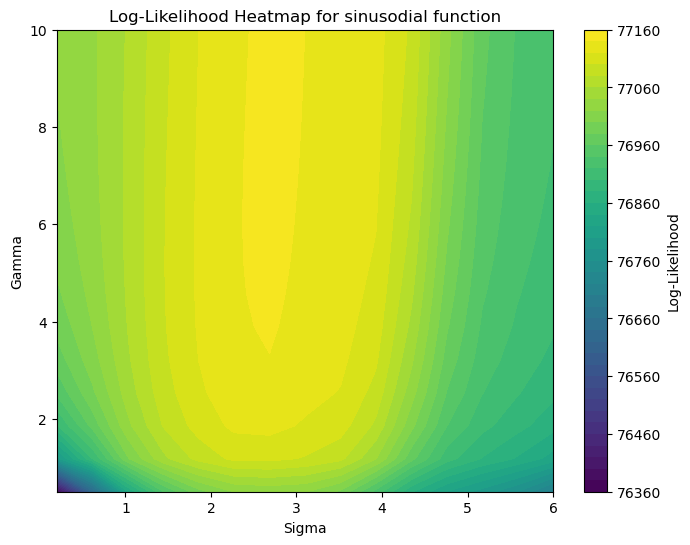

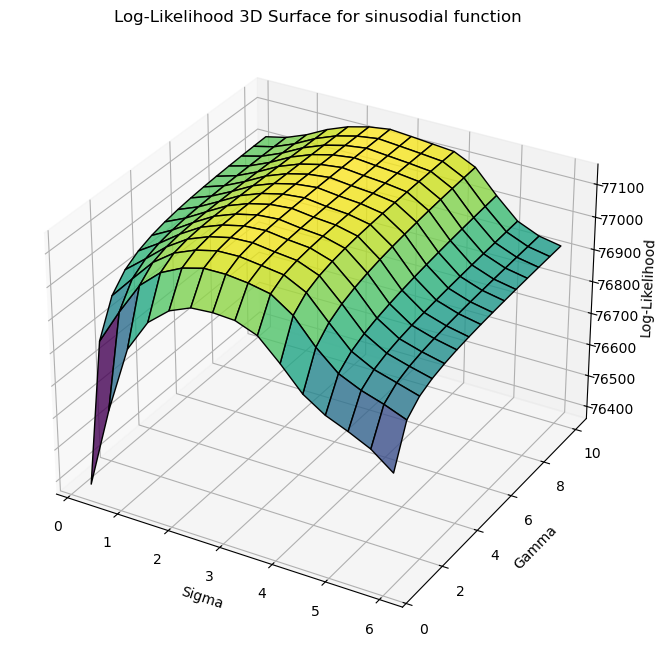

In [159]:
X = np.array(X_expanded)
t = np.array(t_expanded)


# take 2
from scipy.stats import multivariate_normal, poisson
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming compute_cov_matrix, compute_gradient, and compute_hessian are defined

# Define parameter ranges
sigma_values = np.linspace(0.2, 6, 15)  # Sigma values
gamma_values = np.linspace(0.5, 10, 15)  # Gamma values

# Create a grid of parameters
param_grid = list(itertools.product(sigma_values, gamma_values))

# Initialize storage for log-likelihood values
log_likelihoods = np.zeros((len(sigma_values), len(gamma_values)))

# Iterate over the parameter grid
for i, sigma in enumerate(sigma_values):
    for j, gamma in enumerate(gamma_values):
        # Compute covariance matrix with the extended RBF kernel
        Cn = compute_cov_matrix(X, sigma=sigma, gamma=gamma, regularization=1e-6)
        
        # Initialize lambda
        lambda_init = np.ones(X.shape[0])
        
        # Perform Newton's optimization
        for k in range(500):
            grad_f = compute_gradient(t, lambda_init, Cn)
            H = compute_hessian(Cn, lambda_init)
            change = 0.05 * np.linalg.inv(H).dot(grad_f)
            lambda_init += change
            if np.max(np.abs(change)) < 1e-6:
                break
        
        # Compute the log-likelihood
        log_likelihood = t.T @ lambda_init - np.sum(np.exp(lambda_init)) -0.5 *log_det_cholesky((compute_hessian(Cn, lambda_init))) \
                        + multivariate_normal.logpdf(lambda_init, mean=np.zeros(X.shape[0]), cov= Cn)
        # Store the log-likelihood value
        log_likelihoods[i, j] = log_likelihood

# Plotting the landscape
sigma_grid, gamma_grid = np.meshgrid(sigma_values, gamma_values)

# Heatmap
plt.figure(figsize=(8, 6))
plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, levels=50, cmap="viridis")
plt.colorbar(label="Log-Likelihood")
plt.title("Log-Likelihood Heatmap for sinusodial function")
plt.xlabel("Sigma")
plt.ylabel("Gamma")
plt.show()

# 3D Surface Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(sigma_grid, gamma_grid, log_likelihoods.T, cmap="viridis", edgecolor="k", alpha=0.8)
ax.set_title("Log-Likelihood 3D Surface for sinusodial function")
ax.set_xlabel("Sigma")
ax.set_ylabel("Gamma")
ax.set_zlabel("Log-Likelihood")
plt.show()

In [91]:
from scipy.optimize import minimize

# Initial parameters
theta_init = np.array([3.1,3.5], dtype=np.float64)

# Optimize the log-likelihood
result = minimize(
    fun= neg_log_likelihood_function,
    x0=theta_init,
    args=(X, t),
    jac=gradient_log_likelihood,
    method='BFGS'
    )


# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.3f}, {result.x[1]:.3f}]")
print(f"Log-likelihood at optimum: {-result.fun:.3f}")

Optimized parameters: [2.729, 8.157]
Log-likelihood at optimum: 77145.831


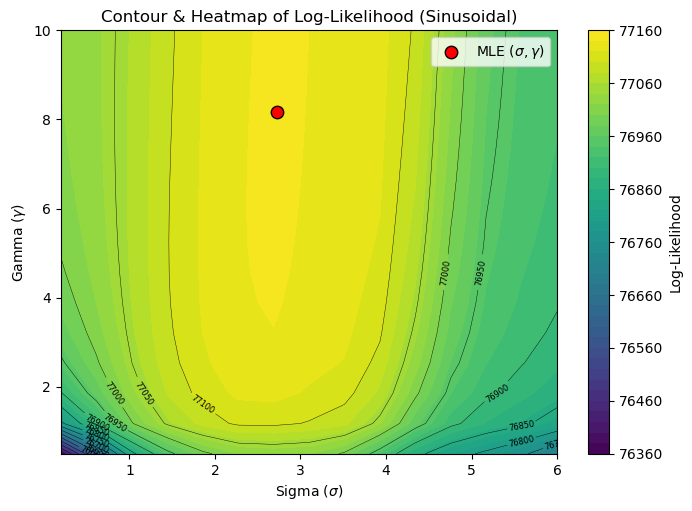

In [161]:
highlight_sigma = 2.729
highlight_gamma = 8.157

plt.figure(figsize=(8,5.5))
contourf = plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, 
                        levels=50, cmap="viridis")  
contour = plt.contour(sigma_grid, gamma_grid, log_likelihoods.T, 
                      levels=15, colors="k", linewidths=0.3)
plt.clabel(contour, inline=True, fontsize=6, fmt="%.0f")
plt.colorbar(contourf, label="Log-Likelihood")

# Mark the special point
plt.scatter(highlight_sigma, highlight_gamma, 
            color="red", s=80, marker="o", edgecolor="k", 
            label="MLE (${\sigma},{\gamma}$)")

plt.title("Contour & Heatmap of Log-Likelihood (Sinusoidal)")
plt.xlabel(r"Sigma ($\sigma$)")
plt.ylabel(r"Gamma ($\gamma$)")
plt.legend()
plt.show()


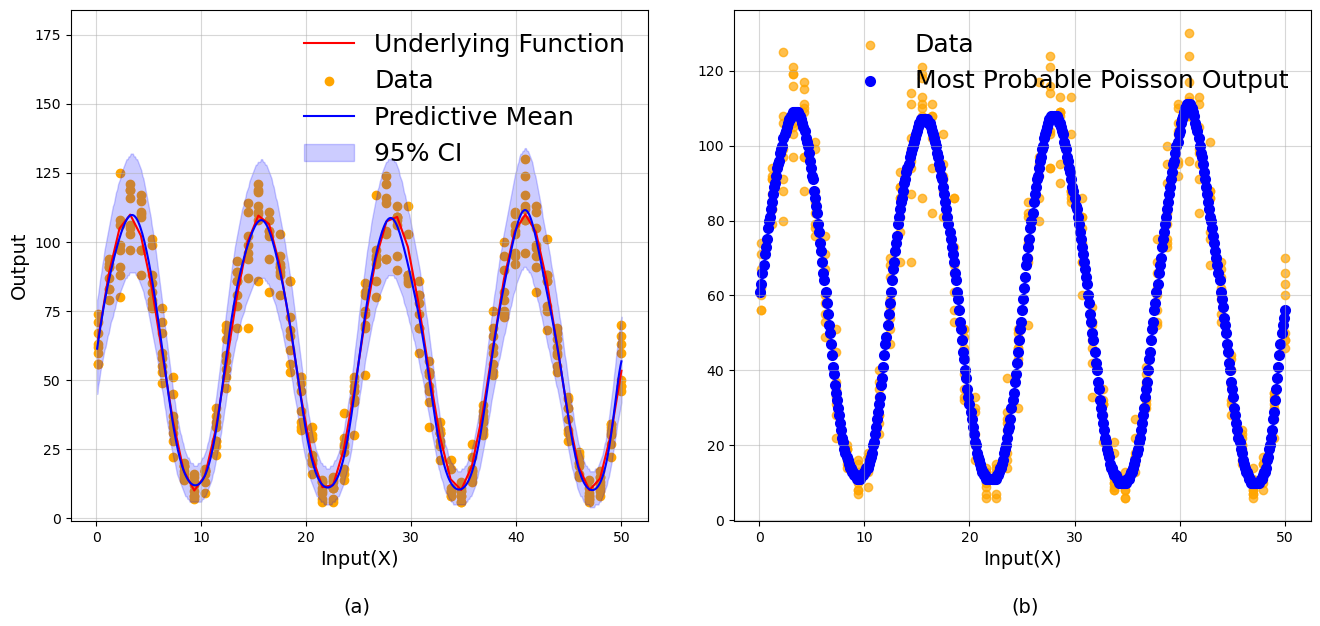

In [20]:
X = np.array(X_expanded)
t = np.array(t_expanded)
alpha_x = np.array(Alpha_expanded)



import matplotlib.pyplot as plt
sigma = 2.729
gamma = 8.157 
Cn = compute_cov_matrix(X, sigma=sigma, gamma=gamma, regularization=1e-6)
    
# Initialize lambda
lambda_init = np.ones(X.shape[0])

# Perform Newton's optimization
for i in range(500):
    grad_f = compute_gradient(t, lambda_init, Cn)
    H = compute_hessian(Cn, lambda_init)
    change = 0.05 * np.linalg.inv(H).dot(grad_f)
    lambda_init += change
    if np.max(change) < 1e-6:
        break


# Define input space for predictions
X_input = np.linspace(0.1, 50, 500)

lambda_predicted = lambda_init
# Storage for predictions
mu_values = []
std_values = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input:
    K = compute_K(X, X_new, sigma= 2.729 , gamma= 8.157)  # Compute K for each X_new
    mean_lambda_nplus1_given_data = K.T @ np.linalg.inv(Cn) @ lambda_predicted  # Predictive mean

    # Variance calculations
    H = compute_hessian(Cn, lambda_predicted)
    c = rbf_kernel_extended(X_new, X_new, sigma= 2.729 , gamma= 8.157) + 1e-6
    var_lambda_nplus1_given_data = abs(
        c - K.T @ np.linalg.inv(Cn) @ K +
        K.T @ np.linalg.inv(Cn) @ np.linalg.inv(H) @ np.linalg.inv(Cn) @ K
    )

    # Append results to the storage
    mu_values.append(mean_lambda_nplus1_given_data.item())
    std_values.append(np.sqrt(var_lambda_nplus1_given_data))

# Convert lists to arrays
mu_values = np.array(mu_values)
std_values = np.array(std_values)

poissoin_output = []
sigma_poissoin = []
for mu, sigma in zip(mu_values, std_values):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log))
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))

    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)


# Monte Carlo parameters
n_samples = 10000 # Number of Monte Carlo samples
k_range = np.arange(0, 140)  # Range of k to evaluate

# Storage for most probable Poisson outputs and confidence intervals
most_probable_output = []
confidence_intervals = []

for mu, sigma in zip(mu_values, std_values):
    # Sample lambda from log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))

    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))

most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bounds = confidence_intervals[:, 0]
upper_bounds = confidence_intervals[:, 1]


# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
axes[0].plot(X, alpha_x, label="Underlying Function", color="red")
axes[0].scatter(X, t, label="Data", color="orange")
axes[0].plot(X_input, poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(X_input, lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI")
axes[0].set_xlabel("Input(X)", fontsize=14)
axes[0].set_ylabel("Output", fontsize=14)
axes[0].set_ylim([min(lower_bounds)-5, max(upper_bounds) + 50])  # Adjust y-axis range
axes[0].legend(fontsize=18, loc ="best", frameon=False)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
axes[1].scatter(X, t, label="Data", color="orange", alpha=0.7)
axes[1].scatter(X_input, most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)
axes[1].set_xlabel("Input(X)", fontsize=14)
axes[0].set_ylim([min(lower_bounds)-5, max(upper_bounds) + 50])  # Adjust y-axis range
axes[1].legend(fontsize=18, loc ="best", frameon=False)
axes[1].grid(alpha=0.5)

# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.7125, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Save the figure (optional, for including in your paper)
plt.savefig("lin+quad.png", dpi=300)

# Show the plots
plt.show()


## Exponentil Decay

     X     Alpha   t
0  0.5  9.753099  10
1  0.5  9.753099  10
2  0.5  9.753099   9
3  0.5  9.753099   8
4  0.5  9.753099   8


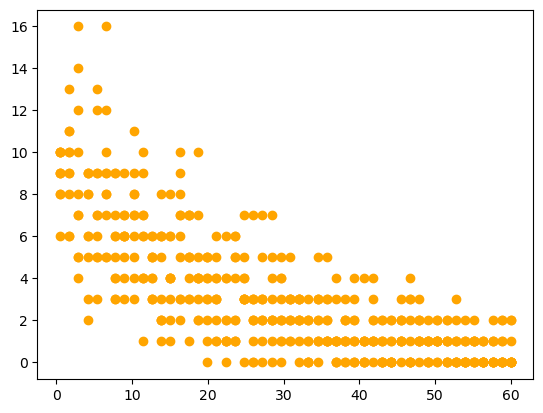

In [21]:
import pandas as pd
# Parameters for the exponential decay function x(t) = c * exp(-λ * t)
c = 10  # Constant multiplier
lambda_exp = 0.05  # Decay rate
np.random.seed(42)
# Number of unique X (time) values to generate
n_samples = 50  # Number of unique time values

# Generate unique time points (input X values)
X_unique = np.linspace(0.5, 60, n_samples)  # Time values from 0 to 10

# Number of instances per unique time value
n_instances_per_X = 10

# Initialize lists to store the expanded data
X_expanded = []
Alpha_expanded = []
t_expanded = []

# Iterate over each unique X (time) value
for x in X_unique:
    alpha_x = c * np.exp(-lambda_exp * x)  # Calculate the rate parameter for the current X
    # Generate multiple t values from Poisson distribution with λ = alpha_x
    t_values = np.random.poisson(alpha_x, n_instances_per_X)
    # Append the current X, its alpha_x, and corresponding t values to the lists
    X_expanded.extend([x] * n_instances_per_X)
    Alpha_expanded.extend([alpha_x] * n_instances_per_X)
    t_expanded.extend(t_values)

# Combine X, Alpha, and t into a DataFrame
data = pd.DataFrame({
    'X': X_expanded,  # Original input X values
    'Alpha': Alpha_expanded,  # Calculated rate parameter
    't': t_expanded  # Poisson-distributed target values
})

# Save the dataset to a CSV file (optional)
data.to_csv('synthetic_data_exponential_decay_corrected.csv', index=False)

# Display the first few rows
print(data.head())

# Convert to numpy arrays
X = np.array(X_expanded)  # Original input X values
t = np.array(t_expanded)  # Poisson-distributed target values
alpha_x = np.array(Alpha_expanded)  # Rate parameter values


plt.scatter(X,t, color = 'orange')
#plt.plot(X, alpha_x )
plt.show()

In [82]:
from scipy.optimize import minimize
import numpy as np

# Initial parameters
theta_init = np.array([0.00025, 5.0], dtype=np.float64)

# Define bounds for parameters (e.g., no negative values)
bounds = [(0.00001, 5), (0.00001, 6)]  # Both parameters >= 0

# Optimize the log-likelihood using L-BFGS-B
result = minimize(
    fun=neg_log_likelihood_function_lin,  # Objective function
    x0=theta_init,                        # Initial guess
    args=(X, t),                          # Additional arguments for the function
    method='L-BFGS-B',
    bounds=bounds                         # Optional parameter bounds
)

# Print the optimization results
print(f"Optimized parameters: [{result.x[0]:.4f}, {result.x[1]:.4f}]")
print(f"Log-likelihood at optimum: {-result.fun:.4f}")


Optimized parameters: [0.0024, 5.0055]
Log-likelihood at optimum: 217.7967


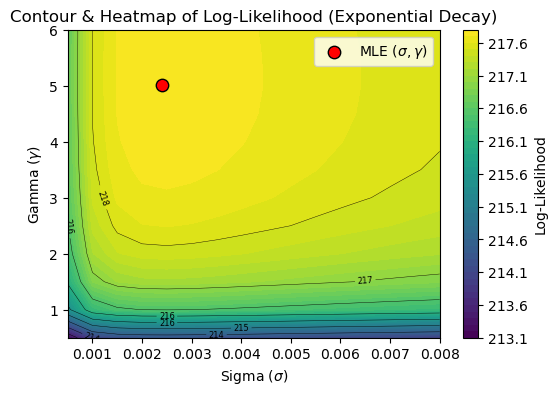

In [225]:
highlight_sigma = 0.0024
highlight_gamma =  5.0055

plt.figure(figsize=(6, 4))
contourf = plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, 
                        levels=50, cmap="viridis")  
contour = plt.contour(sigma_grid, gamma_grid, log_likelihoods.T, 
                      levels=10, colors="k", linewidths=0.3)
plt.clabel(contour, inline=True, fontsize=6, fmt="%.0f")
plt.colorbar(contourf, label="Log-Likelihood")

# Mark the special point
plt.scatter(highlight_sigma, highlight_gamma, 
            color="red", s=80, marker="o", edgecolor="k", 
            label="MLE (${\sigma},{\gamma}$)")

plt.title("Contour & Heatmap of Log-Likelihood (Exponential Decay)")
plt.xlabel(r"Sigma ($\sigma$)")
plt.ylabel(r"Gamma ($\gamma$)")
plt.legend()
plt.show()


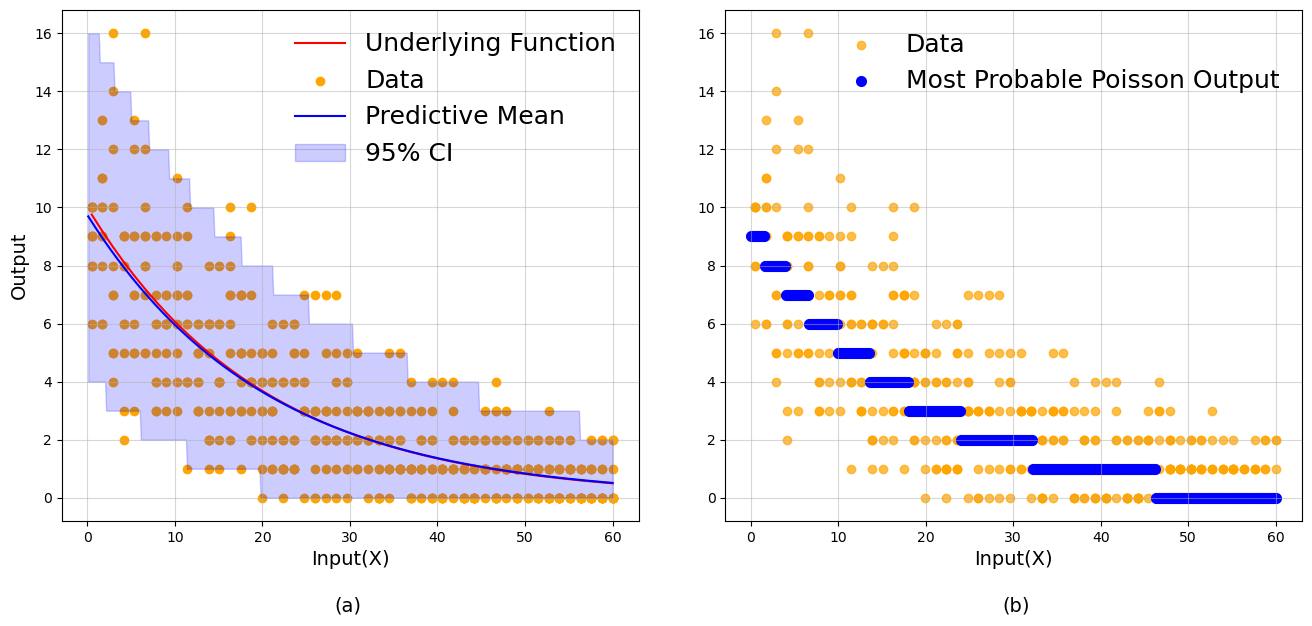

In [22]:
import matplotlib.pyplot as plt
theta1=0.0024
theta2=5.0055
Cn = compute_cov_matrix_lin(X, theta1=0.0024, theta2=5.0055, regularization=1e-5)
    
# Initialize lambda
lambda_init = np.ones(X.shape[0])

# Perform Newton's optimization
for i in range(500):
    grad_f = compute_gradient(t, lambda_init, Cn)
    H = compute_hessian(Cn, lambda_init)
    change = 0.05 * np.linalg.inv(H).dot(grad_f)
    lambda_init += change
    if np.max(change) < 1e-6:
        break


# Define input space for predictions
X_input = np.linspace(0.1, 60, 500)

lambda_predicted = lambda_init
# Storage for predictions
mu_values = []
std_values = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input:
    K = compute_K_lin(X, X_new, 0.0024, 5.0055)  # Compute K for each X_new
    mean_lambda_nplus1_given_data = K.T @ np.linalg.inv(Cn) @ lambda_predicted  # Predictive mean

    # Variance calculations
    H = compute_hessian(Cn, lambda_predicted)
    c = linear_kernel(X_new, X_new, 0.0024,5.0055) + 1e-5
    var_lambda_nplus1_given_data = abs(
        c - K.T @ np.linalg.inv(Cn) @ K +
        K.T @ np.linalg.inv(Cn) @ np.linalg.inv(H) @ np.linalg.inv(Cn) @ K
    )

    # Append results to the storage
    mu_values.append(mean_lambda_nplus1_given_data.item())
    std_values.append(np.sqrt(var_lambda_nplus1_given_data))

# Convert lists to arrays
mu_values = np.array(mu_values)
std_values = np.array(std_values)

poissoin_output = []
sigma_poissoin = []
for mu, sigma in zip(mu_values, std_values):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log))
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))

    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)


# Monte Carlo parameters
n_samples = 10000 # Number of Monte Carlo samples
k_range = np.arange(0, 18)  # Range of k to evaluate

# Storage for most probable Poisson outputs and confidence intervals
most_probable_output = []
confidence_intervals = []

for mu, sigma in zip(mu_values, std_values):
    # Sample lambda from log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))

    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))

most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bounds = confidence_intervals[:, 0]
upper_bounds = confidence_intervals[:, 1]


# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
axes[0].plot(X, alpha_x, label="Underlying Function", color="red")
axes[0].scatter(X, t, label="Data", color="orange")
axes[0].plot(X_input, poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(X_input, lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI")
axes[0].set_xlabel("Input(X)", fontsize=14)
axes[0].set_ylabel("Output", fontsize=14)
axes[0].legend(fontsize=18, loc ="best", frameon=False)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
axes[1].scatter(X, t, label="Data", color="orange", alpha=0.7)
axes[1].scatter(X_input, most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)
axes[1].set_xlabel("Input(X)", fontsize=14)
axes[1].legend(fontsize=18, loc ="best", frameon=False)
axes[1].grid(alpha=0.5)

# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.7125, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Save the figure (optional, for including in your paper)
plt.savefig("lin+quad.png", dpi=300)

# Show the plots
plt.show()


# Synthetic Datasets - 2D examples

Train shape: (720, 4)
Test shape: (180, 4)
           X          Y      Alpha   t
0   0.100000  17.185714   3.297679   4
1  12.914286   4.371429  13.781891   6
2   0.100000  27.864286   4.017168  10
3  12.914286  25.728571  12.212012   7
4  30.000000  21.457143  22.106302  29
           X          Y      Alpha   t
0  25.728571  15.050000  24.421973  28
1  25.728571   8.642857  18.809227  26
2   0.100000  15.050000   3.919116   1
3   0.100000   2.235714   3.777494   3
4  21.457143  30.000000  20.116578  24


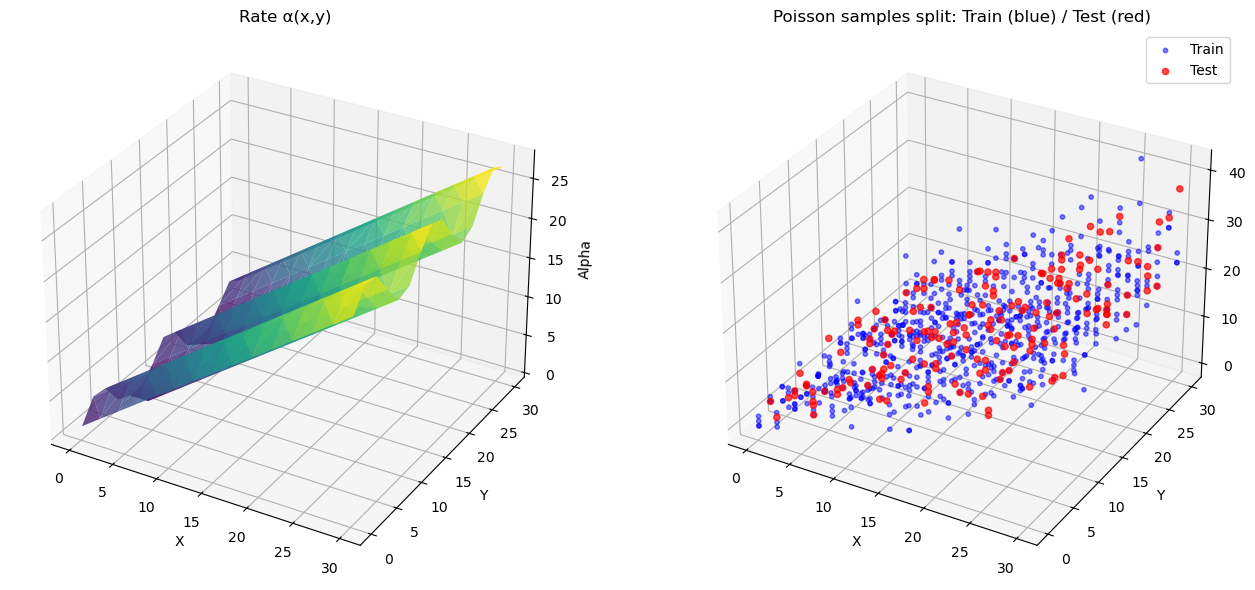

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Reproducibility ---
seed_value = 42
np.random.seed(seed_value)

# Parameters for the 2D rate function
a = 0.8   # slope in x
b = 3.0   # amplitude of sine in y
c = 0.5   # frequency of sine
d = 1.0   # offset

# Number of unique points
n_x = 15
n_y = 15
x_vals = np.linspace(0.1, 30, n_x)
y_vals = np.linspace(0.1, 30, n_y)

# Number of Poisson samples per (x,y)
n_instances_per_point = 4

# Initialize lists
X_expanded, Y_expanded, Alpha_expanded, t_expanded = [], [], [], []

# Iterate over the grid
for x in x_vals:
    for y in y_vals:
        # Define Alpha(x,y)
        alpha_xy = a * x + b * np.sin(c * y) + d
        alpha_xy = max(alpha_xy, 0)  # ensure non-negativity
        # Generate multiple Poisson samples
        poisson_counts = np.random.poisson(alpha_xy, n_instances_per_point)
        # Store
        X_expanded.extend([x] * n_instances_per_point)
        Y_expanded.extend([y] * n_instances_per_point)
        Alpha_expanded.extend([alpha_xy] * n_instances_per_point)
        t_expanded.extend(poisson_counts)

# Combine into DataFrame
data2d = pd.DataFrame({
    'X': X_expanded,
    'Y': Y_expanded,
    'Alpha': Alpha_expanded,
    't': t_expanded
})

# --- Train-Test Split (80-20) ---
train_frac = 0.8
n_total = len(data2d)
indices = np.arange(n_total)
np.random.shuffle(indices)

train_size = int(train_frac * n_total)
train_idx, test_idx = indices[:train_size], indices[train_size:]

train_df = data2d.iloc[train_idx].reset_index(drop=True)
test_df = data2d.iloc[test_idx].reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())
print(test_df.head())

# --- Visualization of Alpha surface ---
fig = plt.figure(figsize=(14, 6))

# True Alpha surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(data2d['X'], data2d['Y'], data2d['Alpha'], cmap='viridis', alpha=0.8)
ax1.set_title("Rate α(x,y)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Alpha")

# Training vs Test samples
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(train_df['X'], train_df['Y'], train_df['t'], c='blue', s=10, alpha=0.5, label="Train")
ax2.scatter(test_df['X'], test_df['Y'], test_df['t'], c='red', s=20, alpha=0.7, label="Test")
ax2.set_title("Poisson samples split: Train (blue) / Test (red)")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("t")
ax2.legend()

plt.tight_layout()
plt.show()


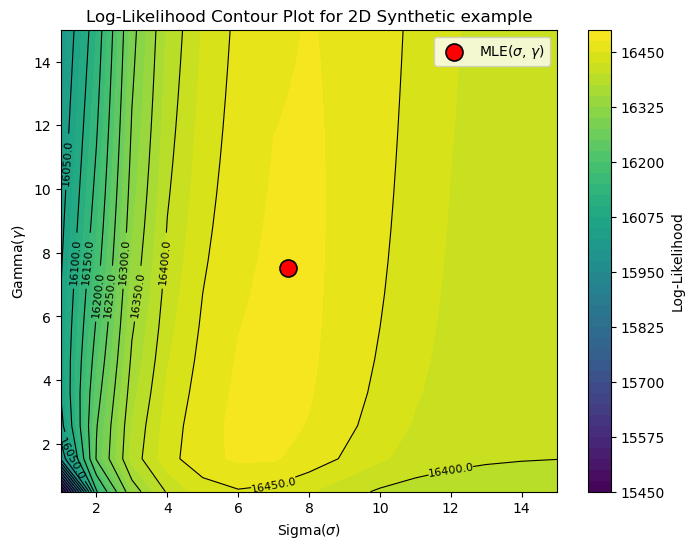

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Both the heatmap and the optimized hyperparameter is calculated using Amarel Coumputing node, takes too long to run on local system

# Load the saved log-likelihood matrix
log_likelihoods = np.load(r"C:\Users\Anushka\Downloads\heatmap.npy")  # path to your file

# Define the parameter grids (use the same values you used to generate the matrix)
sigma_values = np.linspace(1, 15, log_likelihoods.shape[0])
gamma_values = np.linspace(0.5, 15, log_likelihoods.shape[1])
sigma_grid, gamma_grid = np.meshgrid(sigma_values, gamma_values)

# Optimized values
sigma_opt = 7.399
gamma_opt = 7.511

# Contour plot
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sigma_grid, gamma_grid, log_likelihoods.T, levels=50, cmap="viridis")
contour_lines = plt.contour(sigma_grid, gamma_grid, log_likelihoods.T, levels=20, colors="black", linewidths=0.8)

plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.1f")  # label contour lines
plt.colorbar(contourf, label="Log-Likelihood")

# Axis labels with Greek symbols
plt.xlabel(r"Sigma($\sigma$)")
plt.ylabel(r"Gamma($\gamma$)")
plt.title(r"Log-Likelihood Contour Plot for 2D Synthetic example")

# Add optimized point
plt.scatter(sigma_opt, gamma_opt, color="red",  edgecolors="black", linewidth=1.2, marker="o", s=150, label=r"MLE($\sigma$, $\gamma$)")

# Annotate the point
#plt.text(sigma_opt + 0.3, gamma_opt + 0.3, r"MLE($\sigma$, $\gamma$)", color="red", fontsize=10)

# Legend
plt.legend()

plt.show()


In [47]:
# check the R^2 score with 
sigma = 7.399
gamma = 7.511
X = np.array(train_df[ ["X", "Y"]])
t = np.array(train_df[ ["t"]]).reshape(-1)
Cn_2d = compute_cov_matrix(X, sigma=sigma, gamma=gamma, regularization=1e-6)
    
# Initialize lambda
lambda_init_2d = np.ones(X.shape[0])

# Perform Newton's optimization
for i in range(2500):
    grad_f_2d = compute_gradient(t, lambda_init_2d, Cn_2d)
    H_2d = compute_hessian(Cn_2d, lambda_init_2d)
    change = 0.05 * np.linalg.inv(H_2d).dot(grad_f_2d)
    lambda_init_2d += change
    if np.max(change) < 1e-6:
        break
lambda_predicted_2d = lambda_init_2d


In [24]:
# Define X (features) and y (target)
# Define the new feature (index 0 to 96) instead of 'hour'
X_test = np.array(test_df[ ["X", "Y"]])  # Only use temperature as the other feature
y_test = np.array(test_df[ ["t"]])  # Traffic volume as the target variable

#X_test.loc[:, 'temp'] = X_test['temp'] * 24

# Define input space for predictions
X_input_rental = np.array(X_test)

lambda_predicted_rental = lambda_init_2d
# Storage for predictions
mu_values_rental = []
std_values_rental = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input_rental:
    K_rental = compute_K(X, X_new, sigma= 7.399, gamma= 7.511 )  # Compute K for each X_new
    mean_lambda_nplus1_given_data_rental = K_rental.T @ np.linalg.inv(Cn_2d) @ lambda_predicted_rental  # Predictive mean

    # Variance calculations
    H_rental = compute_hessian(Cn_2d, lambda_predicted_rental)
    c_rental = rbf_kernel_extended(X_new, X_new, sigma= 7.399, gamma= 7.511  ) + 1e-6
    var_lambda_nplus1_given_data_rental = abs(
        c_rental - K_rental.T @ np.linalg.inv(Cn_2d) @ K_rental +
        K_rental.T @ np.linalg.inv(Cn_2d) @ np.linalg.inv(H_rental) @ np.linalg.inv(Cn_2d) @ K_rental
    )

    # Append results to the storage
    mu_values_rental.append(mean_lambda_nplus1_given_data_rental.item())
    std_values_rental.append(np.sqrt(var_lambda_nplus1_given_data_rental))

# Convert lists to arrays
mu_values_rental = np.array(mu_values_rental)
std_values_rental = np.array(std_values_rental)

y_pred = []
for mu, sigma in zip(mu_values_rental, std_values_rental):
    mean_log = mu + sigma**2/2
    y_pred.append(np.exp(mean_log))

y_pred = np.array(y_pred)

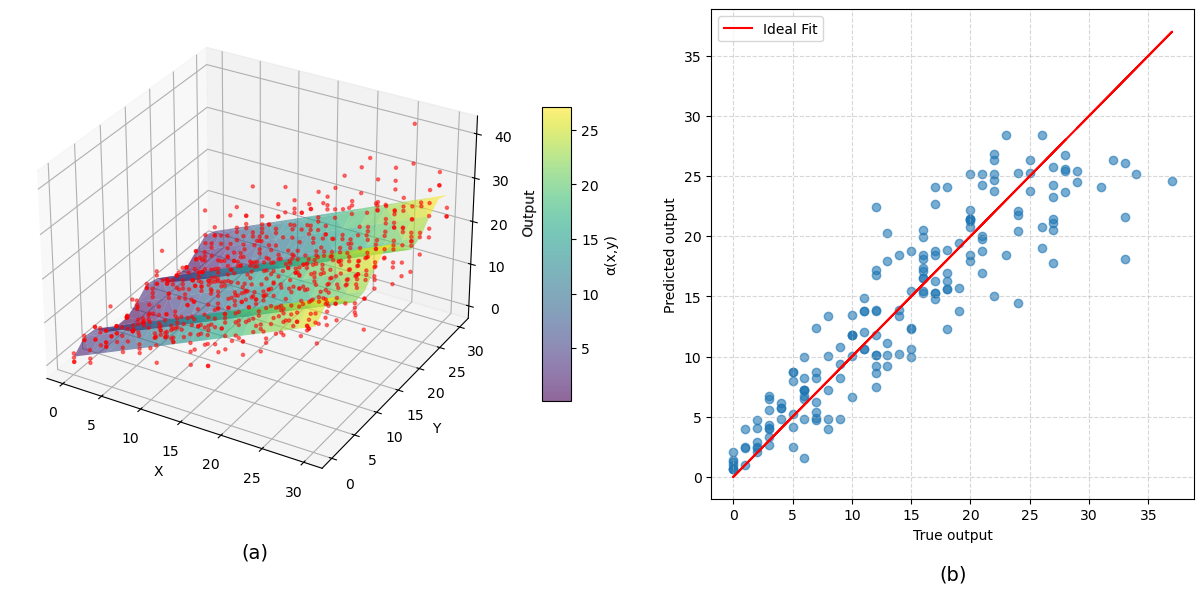

In [45]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create figure
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.75, 1])  # left subplot wider

# --- Subplot (a): 3D surface ---
ax1 = fig.add_subplot(gs[0], projection='3d')
surf = ax1.plot_trisurf(data2d['X'], data2d['Y'], data2d['Alpha'],
                        cmap='viridis', alpha=0.6, linewidth=0.2, edgecolor='none')
ax1.scatter(train_df['X'], train_df['Y'], train_df['t'],
            c='red', s=5, alpha=0.5, label='Training points')
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Output")
fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=10, label='α(x,y)')

# Centered (a) label
ax1.text2D(0.5, -0.12, "(a)", transform=ax1.transAxes, fontsize=14, ha='center')

# --- Subplot (b): Scatter plot ---
ax2 = fig.add_subplot(gs[1])
ax2.scatter(y_test, y_pred, alpha=0.6)
ax2.plot(y_test, y_test, color='red', label='Ideal Fit')
ax2.set_xlabel("True output")
ax2.set_ylabel("Predicted output")
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

# Centered (b) label
ax2.text(0.5, -0.165, "(b)", transform=ax2.transAxes, fontsize=14, ha='center')

plt.tight_layout()
plt.show()


In [46]:
y_pred = np.array(y_pred)
# Calculate the mean of the actual values
y_mean = np.mean(y_test)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_test.flatten() - y_pred) ** 2)

# Calculate TSS (Total Sum of Squares)
tss = np.sum((y_test.flatten() - y_mean) ** 2)

# Calculate R-squared
r_squared = 1 - (rss / tss)
print(f"R-squared with  for test set = {r_squared}")



R-squared with  for test set = 0.8198431636311432


# Real Datasets - Bike Rental

https://www.kaggle.com/datasets/archit9406/bike-sharing

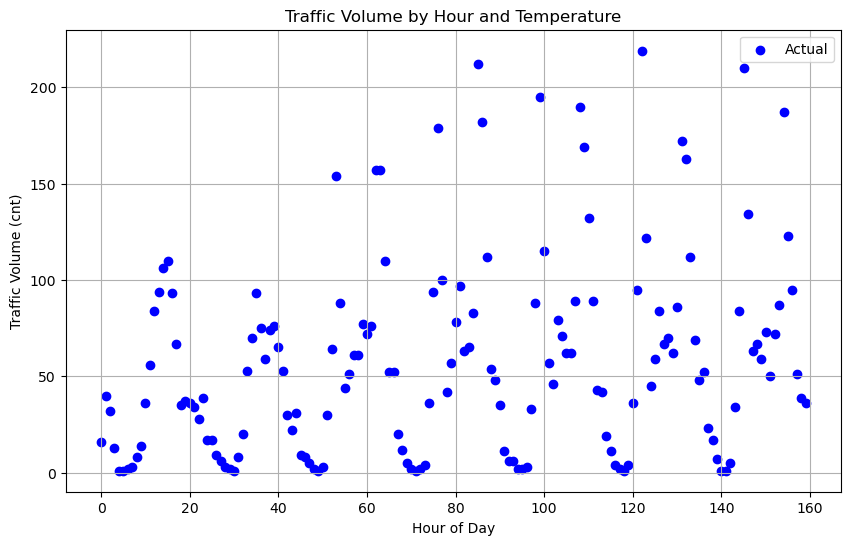

In [3]:
# 160 DataPoints ~ 7 days of data- for the training set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'C:/Users/Anushka/Downloads/bike+sharing+dataset/hour.csv'
df = pd.read_csv(file_path)

# Select the first 97 rows for analysis
df_subset = df.iloc[:160]

# Define X (features) and y (target)
# Define the new feature (index 0 to 96) instead of 'hour'
X = df_subset[['temp', 'hum', 'weekday']]  # Only use temperature as the other feature
y = df_subset['cnt']  # Traffic volume as the target variable


# Plot actual vs predicted traffic volume
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(0,160), y, label='Actual', color='blue')
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Volume (cnt)')
plt.title('Traffic Volume by Hour and Temperature')
plt.legend()
plt.grid()
plt.show()


#### With hour and weekday as the input feature - hence it is a 2D real dataset

In [2]:
X = df_subset[[ 'hr', 'weekday']]  # Only use temperature as the other feature
y = df_subset['cnt']  # Traffic volume as the target variable
X = np.array(X)

R-squared with sigma = 1.92800719 and gamma = 7.18874414 for train set = 0.9775907180072786


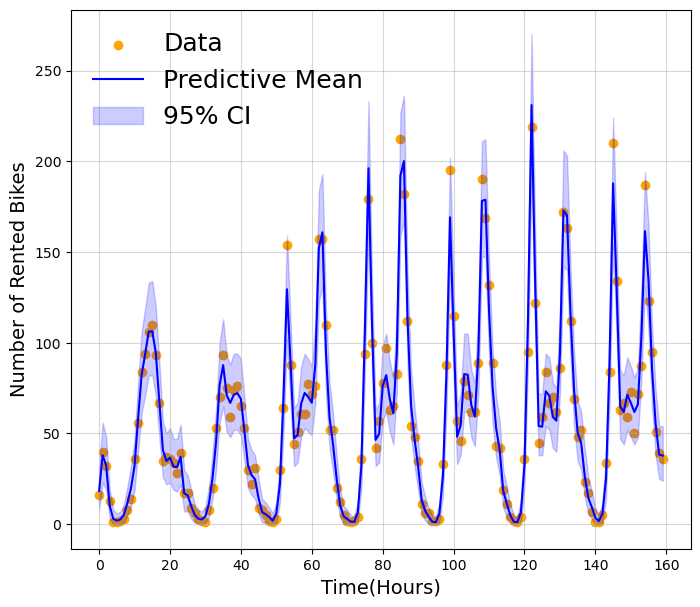

In [5]:
# optimized hyperparameters are found in a seperate search which is not included here, but follow similar pipeline 
sigma = 1.92800719
gamma = 7.18874414
X_rental = X
t_rental = y

Cn_rental = compute_cov_matrix(X_rental, sigma=sigma, gamma=gamma, regularization=1e-6)
    
# Initialize lambda
lambda_init_rental = np.ones(X_rental.shape[0])

# Perform Newton's optimization
for i in range(500):
    grad_f_rental = compute_gradient(t_rental, lambda_init_rental, Cn_rental)
    H_rental = compute_hessian(Cn_rental, lambda_init_rental)
    change = 0.05 * np.linalg.inv(H_rental).dot(grad_f_rental)
    lambda_init_rental += change
    if np.max(change) < 1e-6:
        break



lambda_predicted_rental = lambda_init_rental
X_input_rental = X
# Storage for predictions
mu_values_rental = []
std_values_rental = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input_rental:
    K_rental = compute_K(X_rental, X_new, sigma= 1.92800719, gamma= 7.18874414)  # Compute K for each X_new
    mean_lambda_nplus1_given_data_rental = K_rental.T @ np.linalg.inv(Cn_rental) @ lambda_predicted_rental  # Predictive mean

    # Variance calculations
    H_rental = compute_hessian(Cn_rental, lambda_predicted_rental)
    c_rental = rbf_kernel_extended(X_new, X_new, sigma= 1.92800719, gamma= 7.18874414 ) + 1e-6
    var_lambda_nplus1_given_data_rental = abs(
        c_rental - K_rental.T @ np.linalg.inv(Cn_rental) @ K_rental +
        K_rental.T @ np.linalg.inv(Cn_rental) @ np.linalg.inv(H_rental) @ np.linalg.inv(Cn_rental) @ K_rental
    )

    # Append results to the storage
    mu_values_rental.append(mean_lambda_nplus1_given_data_rental.item())
    std_values_rental.append(np.sqrt(var_lambda_nplus1_given_data_rental))

# Convert lists to arrays
mu_values_rental = np.array(mu_values_rental)
std_values_rental = np.array(std_values_rental)


y_pred = []
for mu, sigma in zip(mu_values_rental, std_values_rental):
    mean_log = mu + sigma**2/2
    y_pred.append(np.exp(mean_log))

y_pred = np.array(y_pred)
# Calculate the mean of the actual values
y_mean = np.mean(y)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y - y_pred) ** 2)

# Calculate TSS (Total Sum of Squares)
tss = np.sum((y - y_mean) ** 2)

# Calculate R-squared
r_squared = 1 - (rss / tss)

print(f"R-squared with sigma = 1.92800719 and gamma = {gamma} for train set = {r_squared}")


# Monte Carlo parameters
n_samples = 5000 # Number of Monte Carlo samples
k_range = np.arange(0, 350)  # Range of k to evaluate

# Storage for most probable Poisson outputs and confidence intervals
most_probable_output = []
confidence_intervals = []

for mu, sigma in zip(mu_values_rental, std_values_rental):
    # Sample lambda from log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))

    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))

most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bound_rental = confidence_intervals[:, 0]
upper_bound_rental = confidence_intervals[:, 1]


# Plot the Gaussian Process prediction
plt.figure(figsize=(8, 7))
plt.scatter(np.arange(160), t_rental, label = "Data", color = "orange")
plt.plot(np.arange(160), y_pred, label="Predictive Mean", color="blue")
plt.fill_between(np.arange(160), lower_bound_rental, upper_bound_rental, color="blue", alpha=0.2, label="95% CI")
plt.xlabel("Time(Hours)", fontsize=14)
plt.ylabel("Number of Rented Bikes", fontsize=14)
plt.legend(fontsize=18, loc = "best", frameon = False)
plt.grid(alpha=0.5)
plt.show()


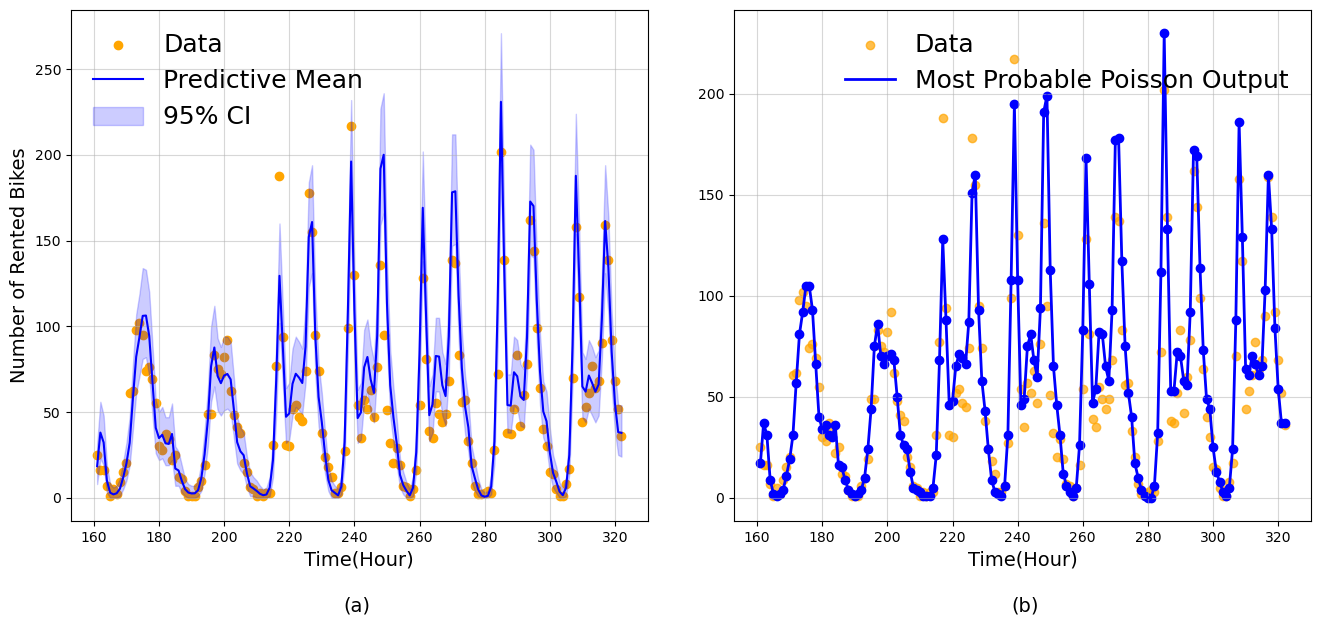

In [67]:
df_test = df.iloc[161:323]
from scipy.stats import poisson

# Define X (features) and y (target)
# Define the new feature (index 0 to 96) instead of 'hour'
X_test = df_test[ ['hr', 'weekday']]  # Only use temperature as the other feature
y_test = df_test['cnt']  # Traffic volume as the target variable

#X_test.loc[:, 'temp'] = X_test['temp'] * 24

# Define input space for predictions
X_input_rental = np.array(X_test)

mu_values_rental = []
std_values_rental = []

# Loop over each X_new to compute predictive mean and standard deviation
for X_new in X_input_rental:
    K_rental = compute_K(X_rental, X_new, sigma= 1.92800719, gamma= 7.18874414)  # Compute K for each X_new
    mean_lambda_nplus1_given_data_rental = K_rental.T @ np.linalg.inv(Cn_rental) @ lambda_predicted_rental  # Predictive mean

    # Variance calculations
    H_rental = compute_hessian(Cn_rental, lambda_predicted_rental)
    c_rental = rbf_kernel_extended(X_new, X_new, sigma= 1.92800719, gamma= 7.18874414 ) + 1e-6
    var_lambda_nplus1_given_data_rental = abs(
        c_rental - K_rental.T @ np.linalg.inv(Cn_rental) @ K_rental +
        K_rental.T @ np.linalg.inv(Cn_rental) @ np.linalg.inv(H_rental) @ np.linalg.inv(Cn_rental) @ K_rental
    )

    # Append results to the storage
    mu_values_rental.append(mean_lambda_nplus1_given_data_rental.item())
    std_values_rental.append(np.sqrt(var_lambda_nplus1_given_data_rental))


poissoin_output = []
sigma_poissoin = []
for mu, sigma in zip(mu_values_rental, std_values_rental):
    mean_log = mu + sigma**2/2
    poissoin_output.append(np.exp(mean_log))
    sigma_poissoin.append(np.sqrt(np.exp(mean_log)+ np.exp(2* mean_log) * (np.exp(sigma**2) -1)))
    
poissoin_output = np.array(poissoin_output)        
sigma_poissoin = np.array(sigma_poissoin)

# Compute confidence intervals
lower_bound = poissoin_output - 2 * sigma_poissoin
upper_bound = poissoin_output + 2 * sigma_poissoin

# Storage for the most probable Poisson outputs (mode) and probabilities
most_probable_output = []
most_probable_probability = []

# Monte Carlo parameters
n_samples = 5000 # Number of Monte Carlo samples
k_range = np.arange(0, 350)  # Range of k to evaluate

# Storage for most probable Poisson outputs and confidence intervals
most_probable_output = []
confidence_intervals = []

for mu, sigma in zip(mu_values_rental, std_values_rental):
    # Sample lambda from log-normal distribution
    lambda_samples = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)

    # Calculate probabilities for all k values
    monte_carlo_probabilities = []
    for k in k_range:
        poisson_probabilities = poisson.pmf(k, lambda_samples)
        monte_carlo_probabilities.append(np.mean(poisson_probabilities))

    monte_carlo_probabilities = np.array(monte_carlo_probabilities)
    cdf = np.cumsum(monte_carlo_probabilities)

    # Find confidence interval bounds
    lower_prob = 0.025
    upper_prob = 0.975
    k_lower = k_range[np.searchsorted(cdf, lower_prob)]
    k_upper = k_range[np.searchsorted(cdf, upper_prob)]

    # Store most probable output and confidence intervals
    k_argmax = k_range[np.argmax(monte_carlo_probabilities)]
    most_probable_output.append(k_argmax)
    confidence_intervals.append((k_lower, k_upper))

most_probable_output = np.array(most_probable_output)
confidence_intervals = np.array(confidence_intervals)

# Extract confidence intervals
lower_bounds = confidence_intervals[:, 0]
upper_bounds = confidence_intervals[:, 1]


# Create subplots with a shared layout
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # 1 row, 2 columns, adjust figsize as needed

# First plot: Gaussian Process Prediction
axes[0].scatter(np.arange(161, 323), y_test, label="Data", color="orange")
axes[0].plot(np.arange(161, 323), poissoin_output, label="Predictive Mean", color="blue")
axes[0].fill_between(np.arange(161, 323), lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI")
axes[0].set_xlabel("Time(Hour)", fontsize=14)
axes[0].set_ylabel("Number of Rented Bikes", fontsize=14)
axes[0].legend(fontsize=18, loc ="best",  frameon = False)
axes[0].grid(alpha=0.5)

# Second plot: Most Probable Poisson Output
# Second plot: Most Probable Poisson Output
axes[1].scatter(np.arange(161, 323), y_test, label="Data", color="orange", alpha=0.7)
axes[1].plot(np.arange(161, 323), most_probable_output, label="Most Probable Poisson Output", color="blue", linewidth=2)  # Add a line connecting the points
axes[1].scatter(np.arange(161, 323), most_probable_output, color="blue")  # Keep the dots for emphasis
axes[1].set_xlabel("Time(Hour)", fontsize=14)
axes[1].legend(fontsize=18, loc="best",frameon = False)
axes[1].grid(alpha=0.5)


# Add labels below subplots
fig.text(0.295, 0.02, "(a)", fontsize=14)  # Label for first subplot
fig.text(0.7125, 0.02, "(b)", fontsize=14)  # Label for second subplot

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.15, bottom=0.15)  # Adjust bottom to create space for labels

# Save the figure (optional, for including in your paper)
plt.savefig("bike_rental.png", dpi=300)

# Show the plots
plt.show()
